In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

from src import inception_v3_imagenet
from src import imagenet_labels
from src import utils
from src.diff_renderer import make_render_op
from src.utils import angles_to_matrix

In [2]:
width, height = 1000, 1000
mesh = utils.load_obj('resources/dog.obj')
original_texture = mesh.texture_image.copy()
render_op = make_render_op(mesh, width, height)

In [3]:
trans = [0, 0, 2.6]
rotation = [0.4, np.pi+.7, 2.9]
fscale = 0.4
bgcolor = [0.9, 0.9, 0.9]
texture_image = mesh.texture_image

In [4]:
view_matrix = np.vstack((np.hstack((angles_to_matrix(rotation) , np.reshape(trans, (3, 1)) )) , np.array([0, 0, 0, 1])))
view_matrix

array([[ 0.74262977,  0.02322123,  0.66929949,  0.        ],
       [-0.18298798, -0.95433222,  0.23614703,  0.        ],
       [ 0.64421769, -0.29784358, -0.70446631,  2.6       ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [5]:
pixel_center_offset = 0.5
near = 0.1
far = 100.

fmat = [float(width) / float(fscale), float(width) / float(fscale)]
f = 0.5 * (fmat[0] + fmat[1])

center = [width/2.,height/2.]

right  =  (width-(center[0]+pixel_center_offset)) * (near/f)
left   =           -(center[0]+pixel_center_offset)  * (near/f)
top    = -(height-(center[1]+pixel_center_offset)) * (near/f)
bottom =            (center[1]+pixel_center_offset)  * (near/f)


A = (right + left) / (right - left)
B = (top + bottom) / (top - bottom)
C = (far + near) / (far - near)
D = (2 * far * near) / (far - near)

camera_matrix = np.array([
    [2 * near / (right - left), 0, A, 0],
    [0, 2 * near / (top - bottom), B, 0],
    [0, 0, C, D],
    [0, 0, -1, 0]
])

In [6]:
proj_matrix = camera_matrix.dot(view_matrix)

In [7]:
homo_v = np.hstack((mesh.v, np.ones((mesh.v.shape[0], 1) )))
homo_v

array([[ 0.04729923, -0.02962504, -0.28196972,  1.        ],
       [ 0.03527478,  0.01396127, -0.29956182,  1.        ],
       [ 0.06153678,  0.01350783, -0.29312388,  1.        ],
       ..., 
       [ 0.04403177,  0.2615302 ,  0.38719011,  1.        ],
       [ 0.03651725,  0.24862289,  0.39145738,  1.        ],
       [ 0.03867221,  0.26496691,  0.38782987,  1.        ]])

In [10]:
abnormal = proj_matrix.dot(homo_v.reshape((-1, 4, 1)))[:, :, 0]
XY = (abnormal[:,:] / abnormal[3,:]).T
XY

array([[ 0.27282516, -0.0817528 , -1.07254638,  1.        ],
       [ 0.3084223 , -0.15895063, -1.07275418,  1.        ],
       [ 0.2651957 , -0.16326456, -1.07244255,  1.        ],
       ..., 
       [-0.65298731, -0.36386272, -1.08989744,  1.        ],
       [-0.64748836, -0.33217757, -1.09005218,  1.        ],
       [-0.64676643, -0.36937906, -1.09008799,  1.        ]])

(1, -1)

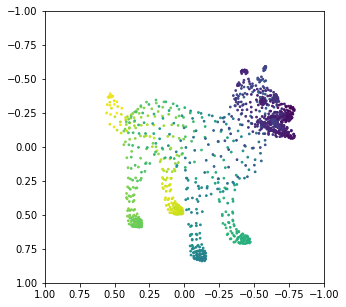

In [11]:

# plt.set_autoscale_on(False)
plt.figure(figsize=(5,5))
plt.scatter(XY[:,0], XY[:, 1], c = XY[:, 2], s=3)
# plt.axes().set_aspect('equal', 'datalim')

plt.xlim([1, -1])
plt.ylim([1, -1])



In [12]:
Z = XY[:,2]

face_depth = np.mean(np.take(Z, mesh.f.flatten()).reshape((-1, 3)), axis=1)

In [13]:
face_depth

array([-1.07258104, -1.07237991, -1.07285156, ..., -1.09000121,
       -1.09020616, -1.09011096])

In [23]:
import matplotlib.cm as cm

In [32]:
fXY = np.take(XY[:,0:2], mesh.f, axis=0)

Xmin, Xmax = np.min(fXY[:,:,0], axis=1), np.max(fXY[:,:,0], axis=1)
Ymin, Ymax = np.min(fXY[:,:,1], axis=1), np.max(fXY[:,:,1], axis=1)

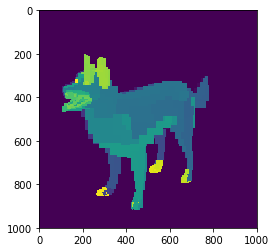

In [45]:
canvas = np.zeros((1000, 1000))
xmin = ((1. + Xmin) * 500.).astype(np.int)
xmax = ((1. + Xmax) * 500.).astype(np.int)
ymin = ((1. + Ymin) * 500.).astype(np.int)
ymax = ((1. + Ymax) * 500.).astype(np.int)

for i in range(len(mesh.f)):
    canvas[ymin[i]:ymax[i], xmin[i]:xmax[i]] = i

plt.imshow(canvas)

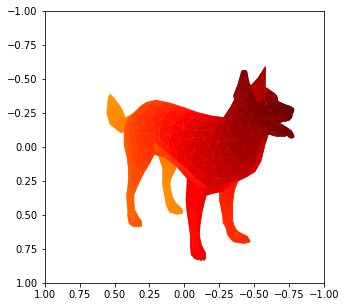

In [24]:
plt.figure(figsize=(5,5))

for i in range(len(mesh.f)):
    tri = np.take(XY[:,0:2], mesh.f[i], axis=0)
    circle = plt.Polygon(tri, fc=cm.hot( (1.1 + face_depth[i]) * 20))
    plt.gca().add_patch(circle)

plt.xlim([1, -1])
plt.ylim([1, -1])

plt.show()

In [28]:
np.array(np.meshgrid(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000)))

array([[[ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        ..., 
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ],
        [ 0.      ,  0.001001,  0.002002, ...,  0.997998,  0.998999,  1.      ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
        [ 0.001001,  0.001001,  0.001001, ...,  0.001001,  0.001001,
          0.001001],
        [ 0.002002,  0.002002,  0.002002, ...,  0.002002,  0.002002,
          0.002002],
        ..., 
        [ 0.997998,  0.997998,  0.997998, ...,  0.997998,  0.997998,
          0.997998],
        [ 0.998999,  0.998999,  0.998999, ...,  0.998999,  0.998999,
          0.998999],
        [ 1.      ,  1.      ,  1.      , .